# Отчет по модели с пробитием baseline

Статкевич Екатерина

In [3]:
import numpy as np
import pandas as pd

import random
from typing import Optional
import lightgbm
from lightgbm.callback import early_stopping
import matplotlib.pyplot as plt

# Постановка задачи

Была предоставлена модель lightgbm, которая на тестовой выборке давала скор 0.12812 (Public Leaderboard)

Цель - провести исследование, в ходе которого получить модель дающую лучший результат.

# 1. Обработка данных

Сначала подгрузим данные и посмотрим на них

In [12]:
!python3 -m pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 3.4 MB/s eta 0:00:0000:0100:01


In [4]:
train = pd.read_parquet('Downloads/items_train.pq')
train.head(10)

,item_id,category_id,request_id,rank,model_a_score,model_a_rank,model_b_score,model_b_rank,model_b_f1,model_b_f2,...,item_stats.clicks,item_stats.clicks_rec,item_stats.last_clicks,item_stats.long_clicks,item_stats.clicks_last_day,item_stats.clicks_rec_last_day,item_stats.segment_contact_conversion,item_stats.seller_contact_conversion,item_stats.segment_click_conversion,item_stats.seller_click_conversion
243499,153904,2,0,199,NaN,NaN,NaN,NaN,NaN,NaN,...,201,157,9,32.870800,26,17,0.026808,0.002500,0.035178,0.050000
243444,426282,2,0,144,NaN,NaN,NaN,NaN,NaN,NaN,...,949,511,31,101.482094,60,46,0.020660,0.002500,0.035813,0.050000
243491,692087,2,0,191,NaN,NaN,NaN,NaN,NaN,NaN,...,1154,692,84,160.471603,128,85,0.023634,0.002500,0.037988,0.050000
243448,825959,2,0,148,11.11,16.0,NaN,NaN,NaN,NaN,...,332,183,14,34.140823,23,10,0.008888,0.002500,0.024652,0.050000
243548,911885,25,0,248,NaN,NaN,NaN,NaN,NaN,NaN,...,3026,1890,95,475.407562,153,94,0.002561,0.002500,0.033806,0.050000
243369,1108209,5,0,69,NaN,NaN,NaN,NaN,NaN,NaN,...,523,344,33,90.693459,9,3,0.023328,0.002500,0.033457,0.050000
243490,1471158,2,0,190,10.54,20.0,NaN,NaN,NaN,NaN,...,113,72,8,9.300191,16,14,0.027922,0.002500,0.041167,0.050000
243572,1703717,2,0,272,NaN,NaN,NaN,NaN,NaN,NaN,...,184,120,5,12.099404,5,1,0.030179,0.002500,0.038752,0.050000
243492,1764802,25,0,192,NaN,NaN,NaN,NaN,NaN,NaN,...,373,197,54,38.809532,242,152,0.002299,0.000572,0.021448,0.013377
243431,1818376,2,0,131,NaN,NaN,NaN,NaN,NaN,NaN,...,104,70,15,9.505854,31,28,0.026340,0.002500,0.034875,0.050000


Посмотрим на размер самих данных

In [18]:
train.shape

(40623600, 49)

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40623600 entries, 243499 to 1017236
Data columns (total 49 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   item_id                                int64  
 1   category_id                            int64  
 2   request_id                             int64  
 3   rank                                   int64  
 4   model_a_score                          float64
 5   model_a_rank                           float64
 6   model_b_score                          float64
 7   model_b_rank                           float64
 8   model_b_f1                             float64
 9   model_b_f2                             float64
 10  model_b_f3                             float64
 11  model_c_score                          float64
 12  model_c_rank                           float64
 13  model_d_score                          float64
 14  model_d_rank                           float

Уже видно, что хотя бы нету категориальных признаков. Теперь изучим данные на пропуски

In [17]:
train.isna().sum()

item_id                                         0
category_id                                     0
request_id                                      0
rank                                            0
model_a_score                            27723714
model_a_rank                             27723714
model_b_score                            27206522
model_b_rank                             27206522
model_b_f1                               27206522
model_b_f2                               27206522
model_b_f3                               27206522
model_c_score                            16432734
model_c_rank                             16432734
model_d_score                            31038797
model_d_rank                             31038797
shows_count                                     0
microcategory_id                                0
location_id                                     0
price                                     1039193
sort_age                                        0


Как видно - для нескольких признаков более чем половина данных с пропусками. Но удалять их не хочется. Посмотрим на гистограммы значений признаков - может повезет и они будут одинаковы?

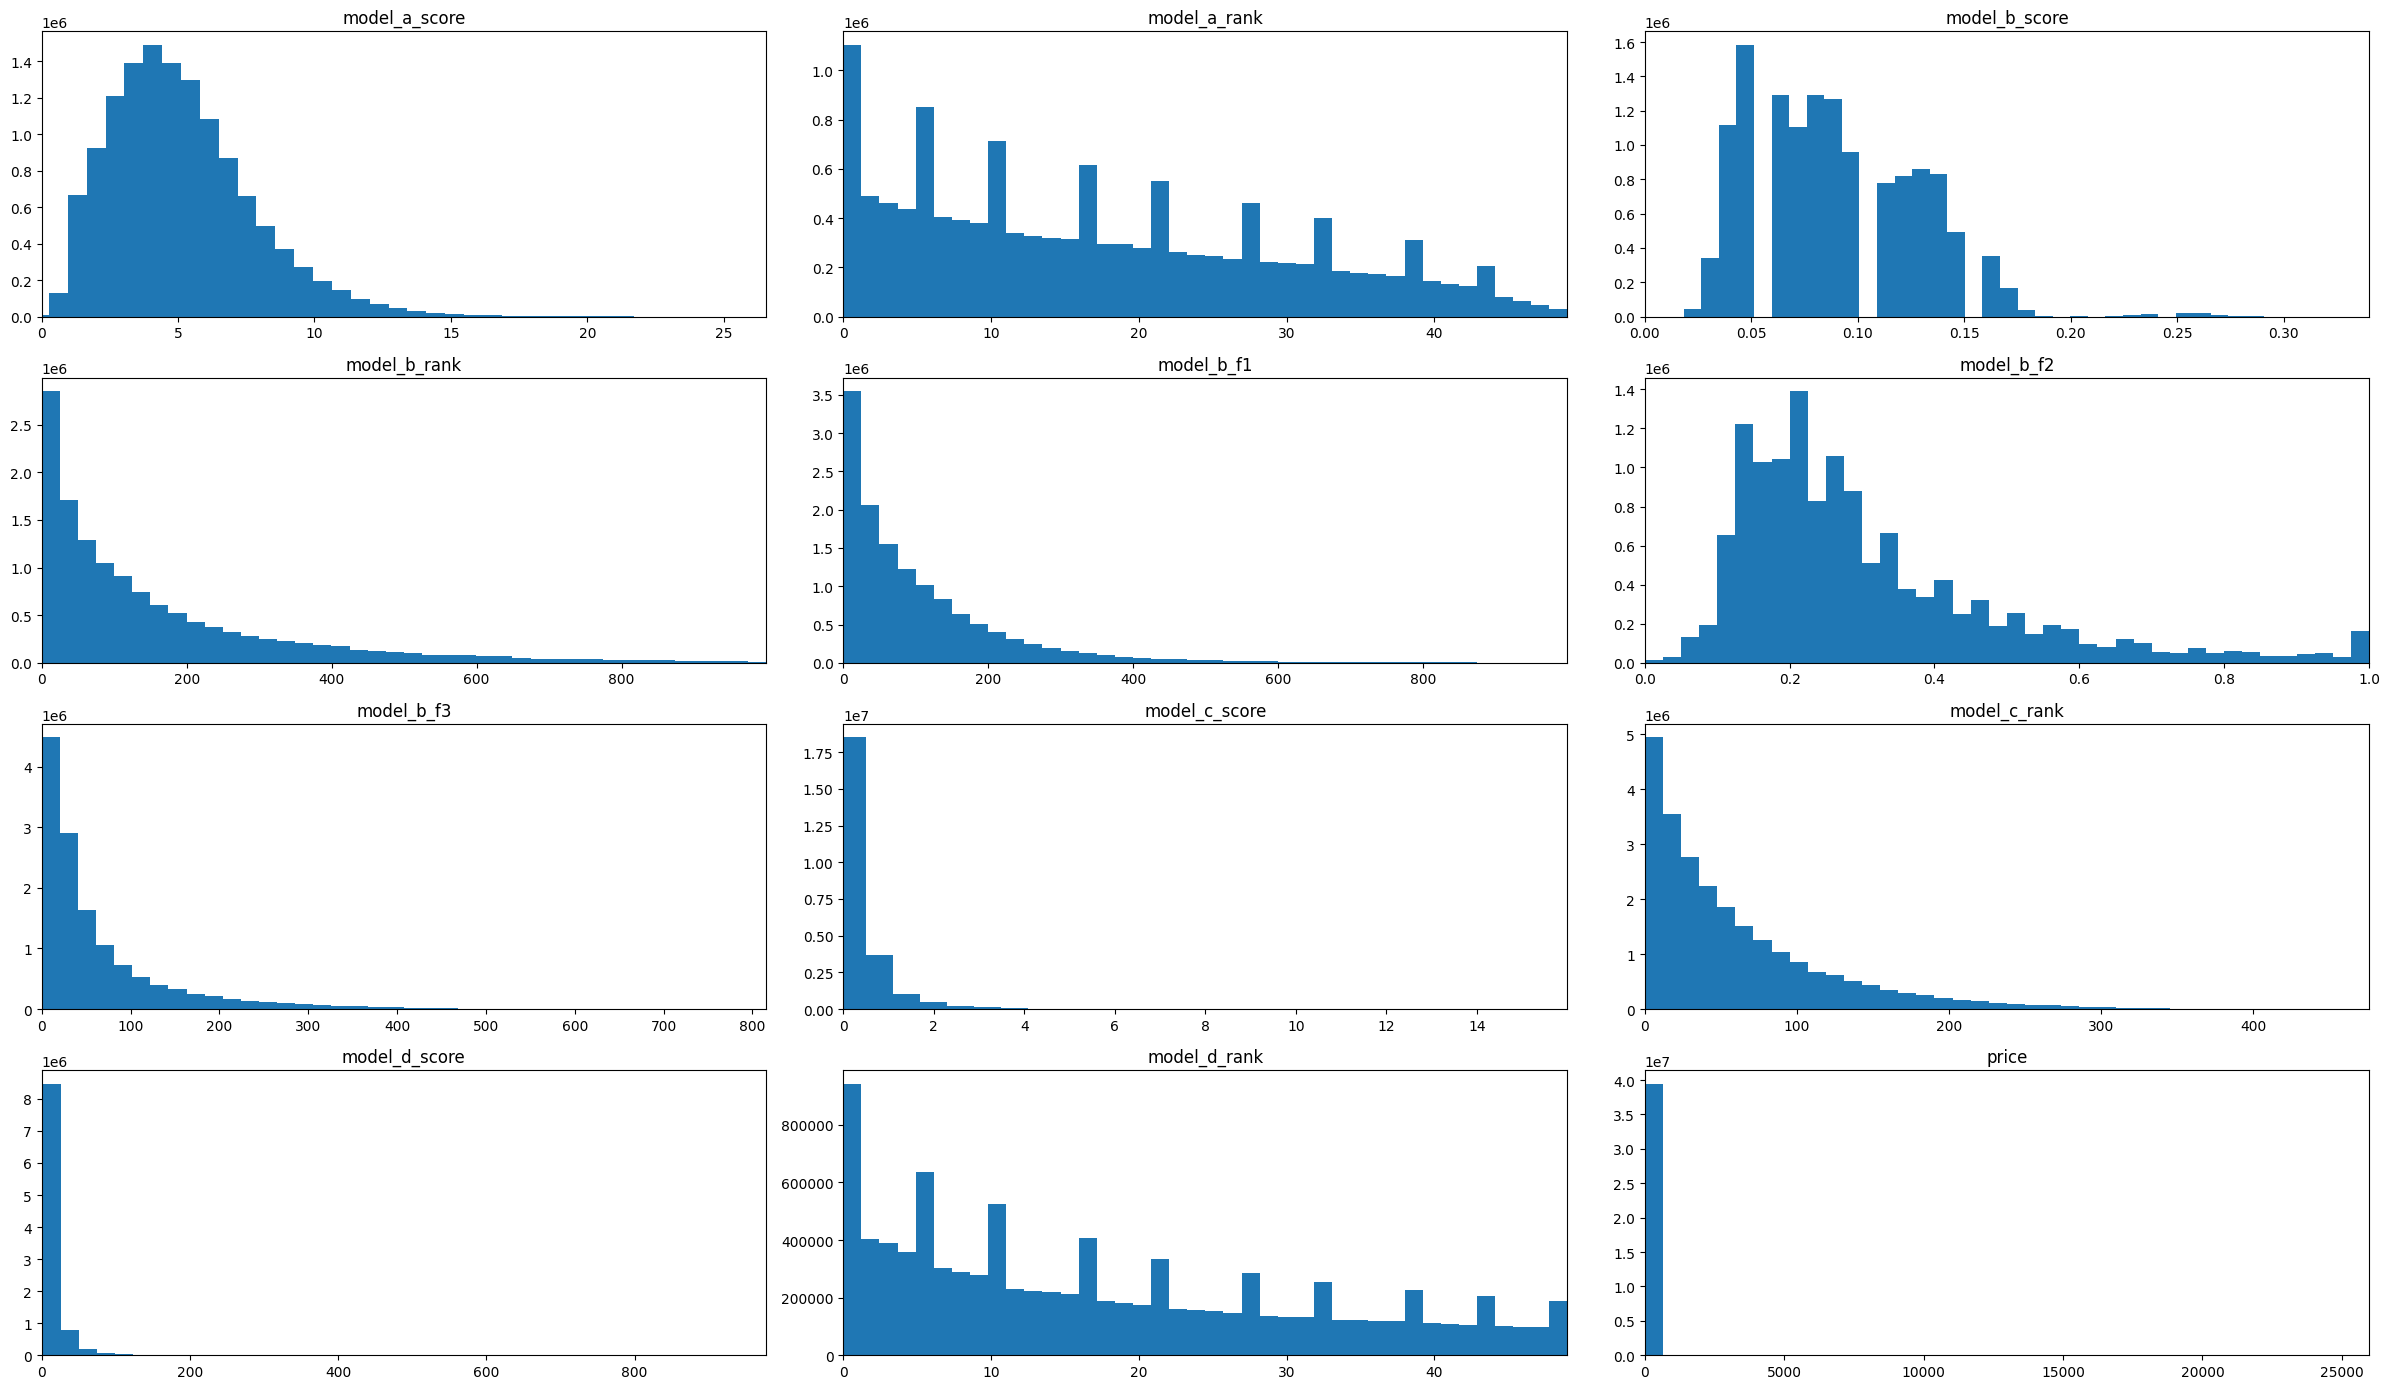

In [25]:
feats = ['model_a_score', 
         'model_a_rank', 
         'model_b_score',
         'model_b_rank', 
         'model_b_f1',
         'model_b_f2',
         'model_b_f3',
         'model_c_score',
         'model_c_rank',
         'model_d_score',
         'model_d_rank',
         'price']

plt.figure(figsize=(24, 14))
for i, f in enumerate(feats):
    plt.subplot(4, 3, i + 1)
    plt.hist(train[f], bins=40)
    plt.title(f)
    plt.xlim((0, np.max(train[f])))
    
plt.tight_layout()

Кажется - можем безболезненно удалить признак price - за исключением выбросов все значения одинаковы. Также хочется изучить на корреляцию остальные признаки

<AxesSubplot: >

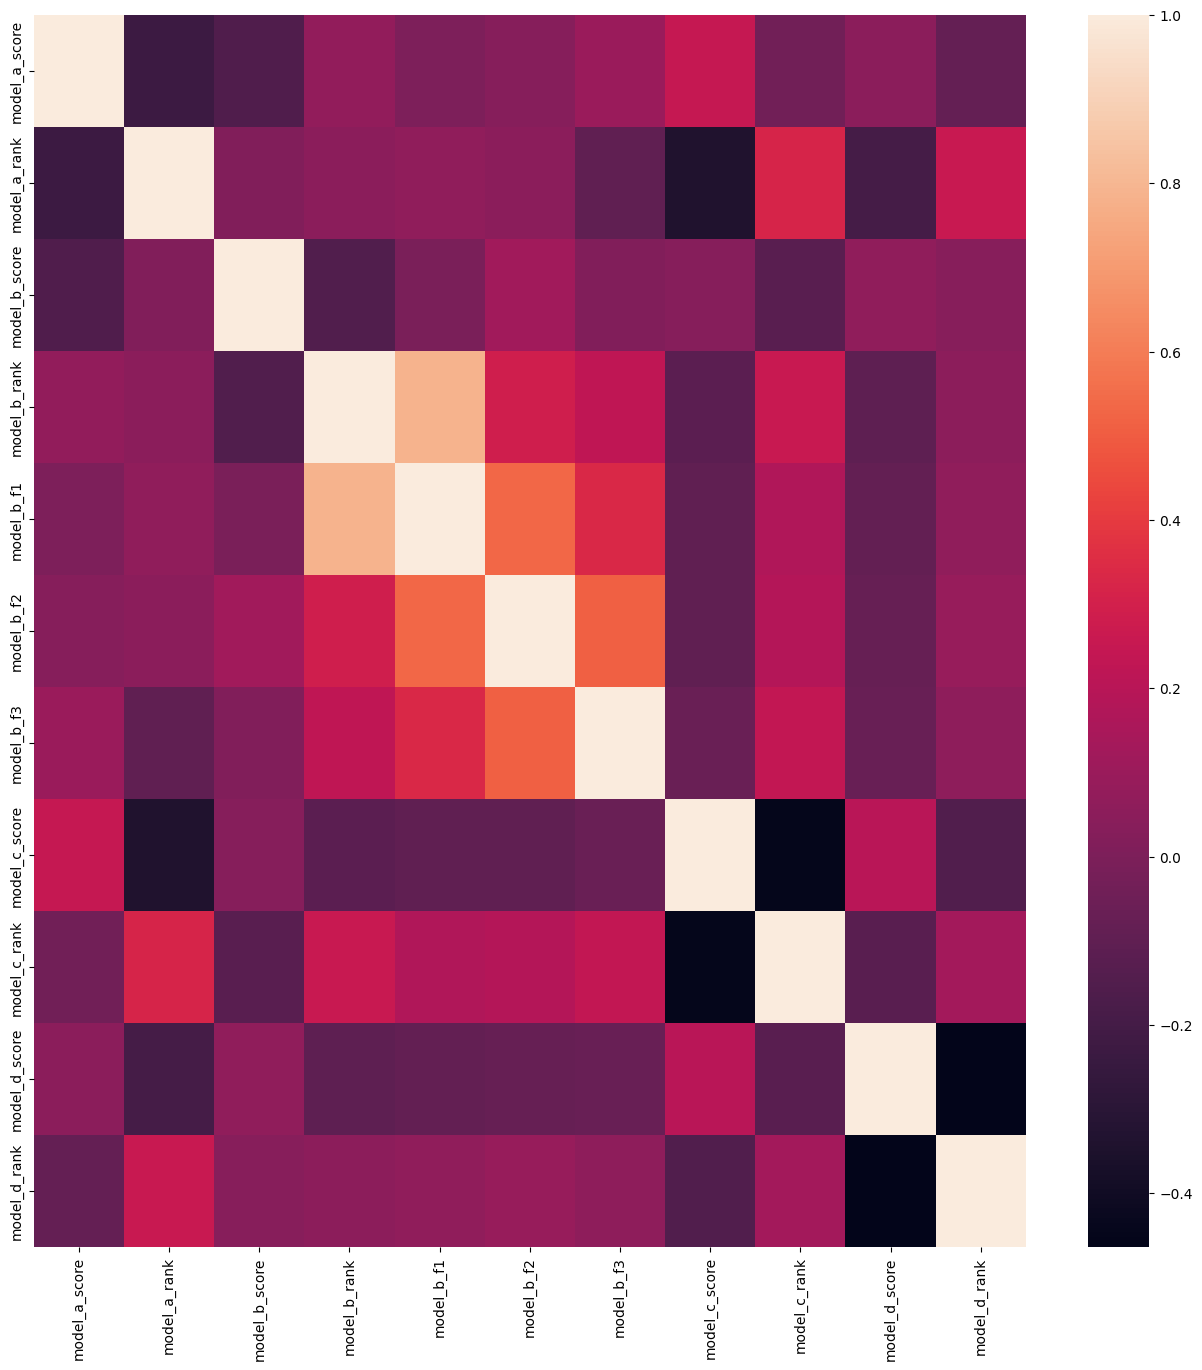

In [27]:
import seaborn as sns

train = train.drop(columns=['price'])
feats = ['model_a_score', 
         'model_a_rank', 
         'model_b_score',
         'model_b_rank', 
         'model_b_f1',
         'model_b_f2',
         'model_b_f3',
         'model_c_score',
         'model_c_rank',
         'model_d_score',
         'model_d_rank']

plt.figure(figsize=(16, 16))
sns.heatmap(train[feats].corr())

Видно что 'model_b_rank' и 'model_b_f1' довольно сильно коррелируют между собой - удалим model_b_f1

In [28]:
train = train.drop(columns=['model_b_f1'])
train.shape

(40623600, 47)

По идее - среди остальных (без NaN) признаков тоже может быть куча ерунды. Для них проведем похожее исследование

In [29]:
features1 = [
       'category_id', 'shows_count', 'microcategory_id',
       'location_id', 'sort_age', 'start_age', 'latitude',
       'longitude', 'item_stats.days',
       'item_stats.contact_conversion', 'item_stats.hides', 'item_stats.shows',
]

features2 = [
       'item_stats.shows_last_day', 'item_stats.shows_rec',
       'item_stats.shows_rec_last_day', 'item_stats.contacts',
       'item_stats.contacts_last_day', 'item_stats.contacts_rec_last_day',
       'item_stats.contacts_rec', 'item_stats.last_contacts',
       'item_stats.delayed_contacts', 'item_stats.delayed_contacts_rec',
       'item_stats.clicks', 'item_stats.clicks_rec',
]

features3 = [
       'item_stats.last_clicks',
       'item_stats.long_clicks', 'item_stats.clicks_last_day',
       'item_stats.clicks_rec_last_day',
       'item_stats.segment_contact_conversion',
       'item_stats.seller_contact_conversion',
       'item_stats.segment_click_conversion',
       'item_stats.seller_click_conversion',
]

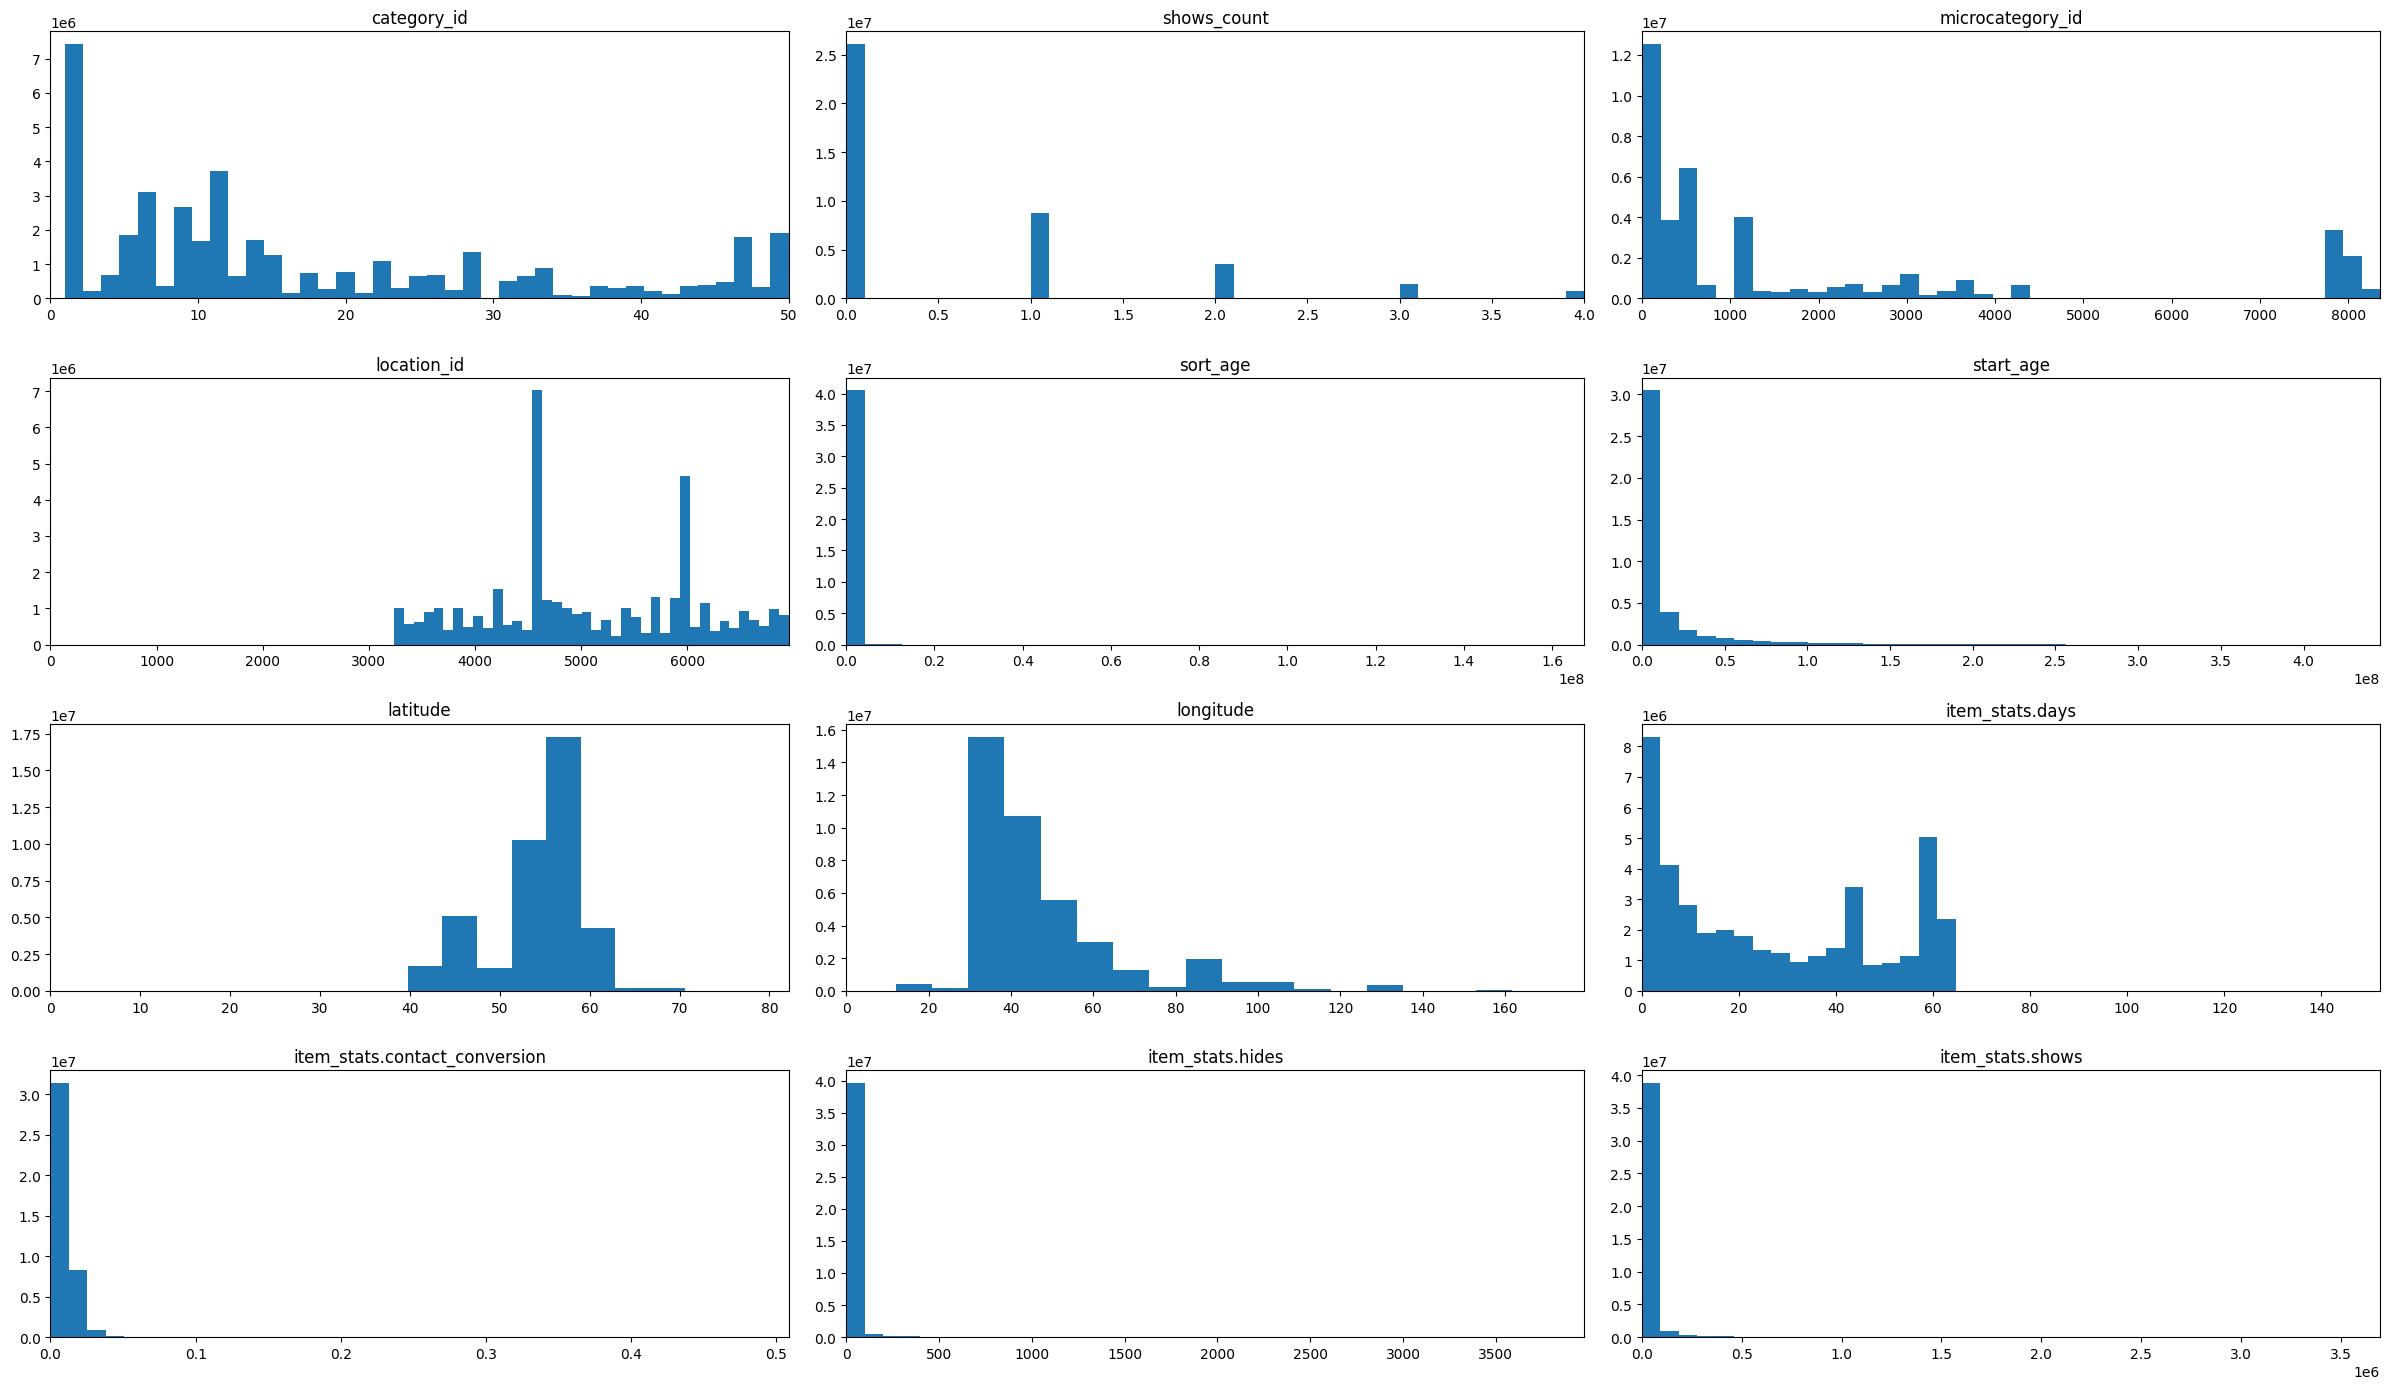

In [30]:
plt.figure(figsize=(24, 14))
for i, f in enumerate(features1):
    plt.subplot(4, 3, i + 1)
    plt.hist(train[f], bins=40)
    plt.title(f)
    plt.xlim((0, np.max(train[f])))
    
plt.tight_layout()

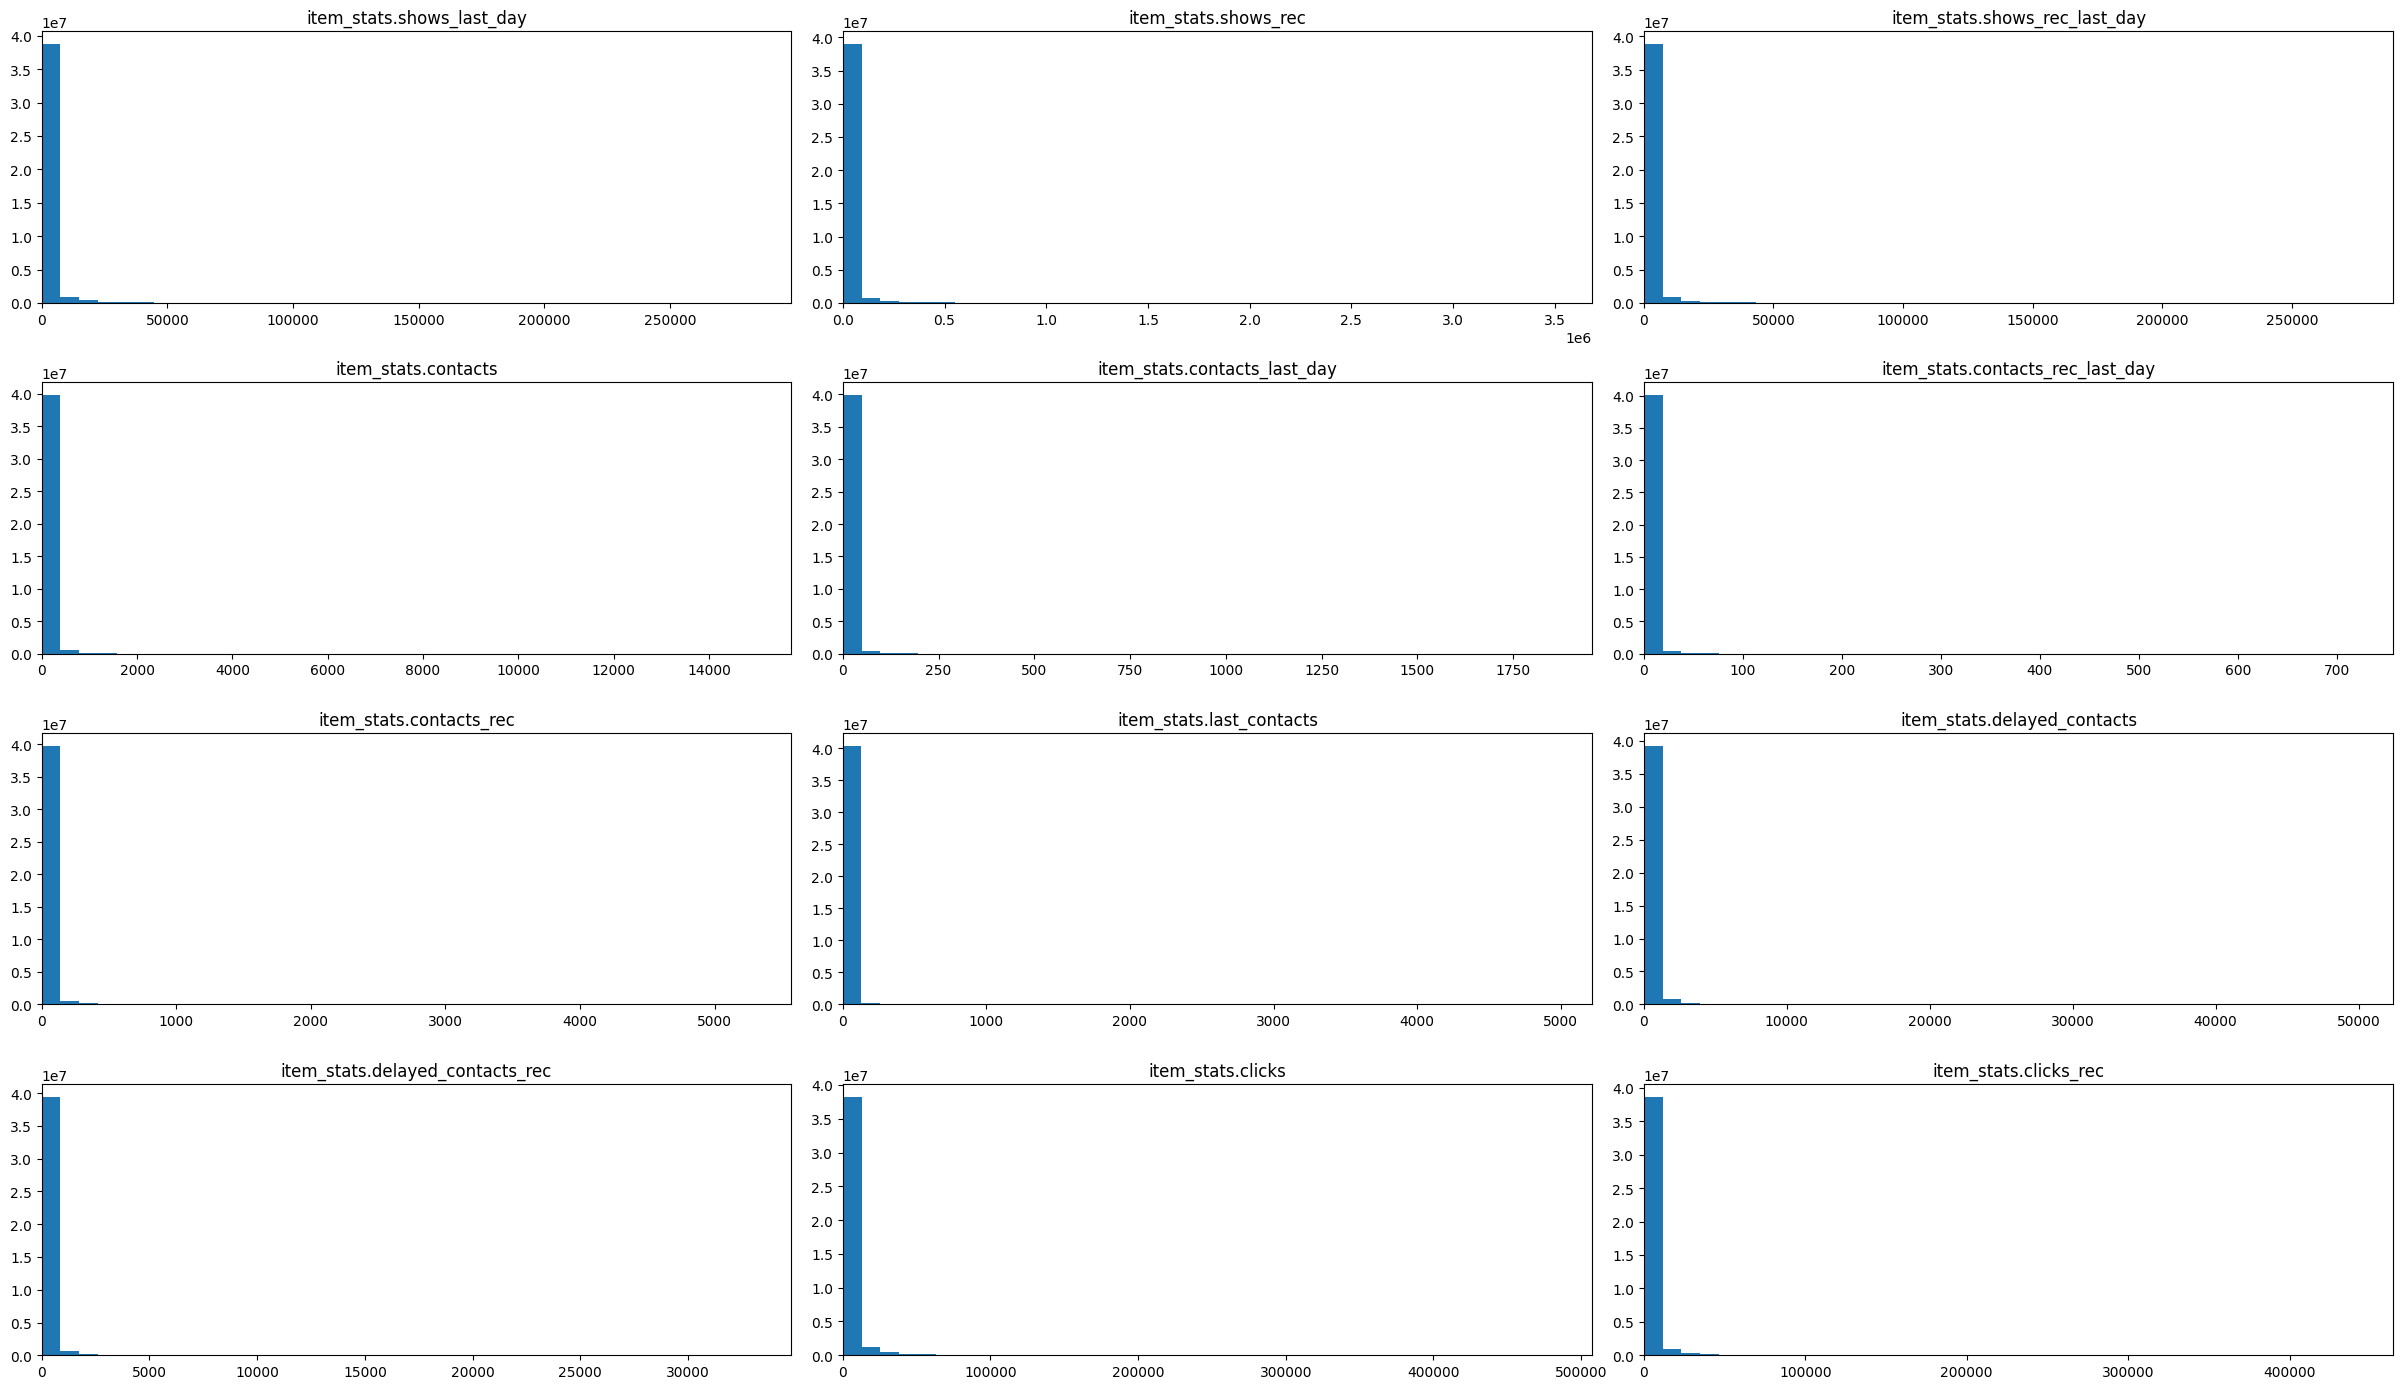

In [31]:
plt.figure(figsize=(24, 14))
for i, f in enumerate(features2):
    plt.subplot(4, 3, i + 1)
    plt.hist(train[f], bins=40)
    plt.title(f)
    plt.xlim((0, np.max(train[f])))
    
plt.tight_layout()

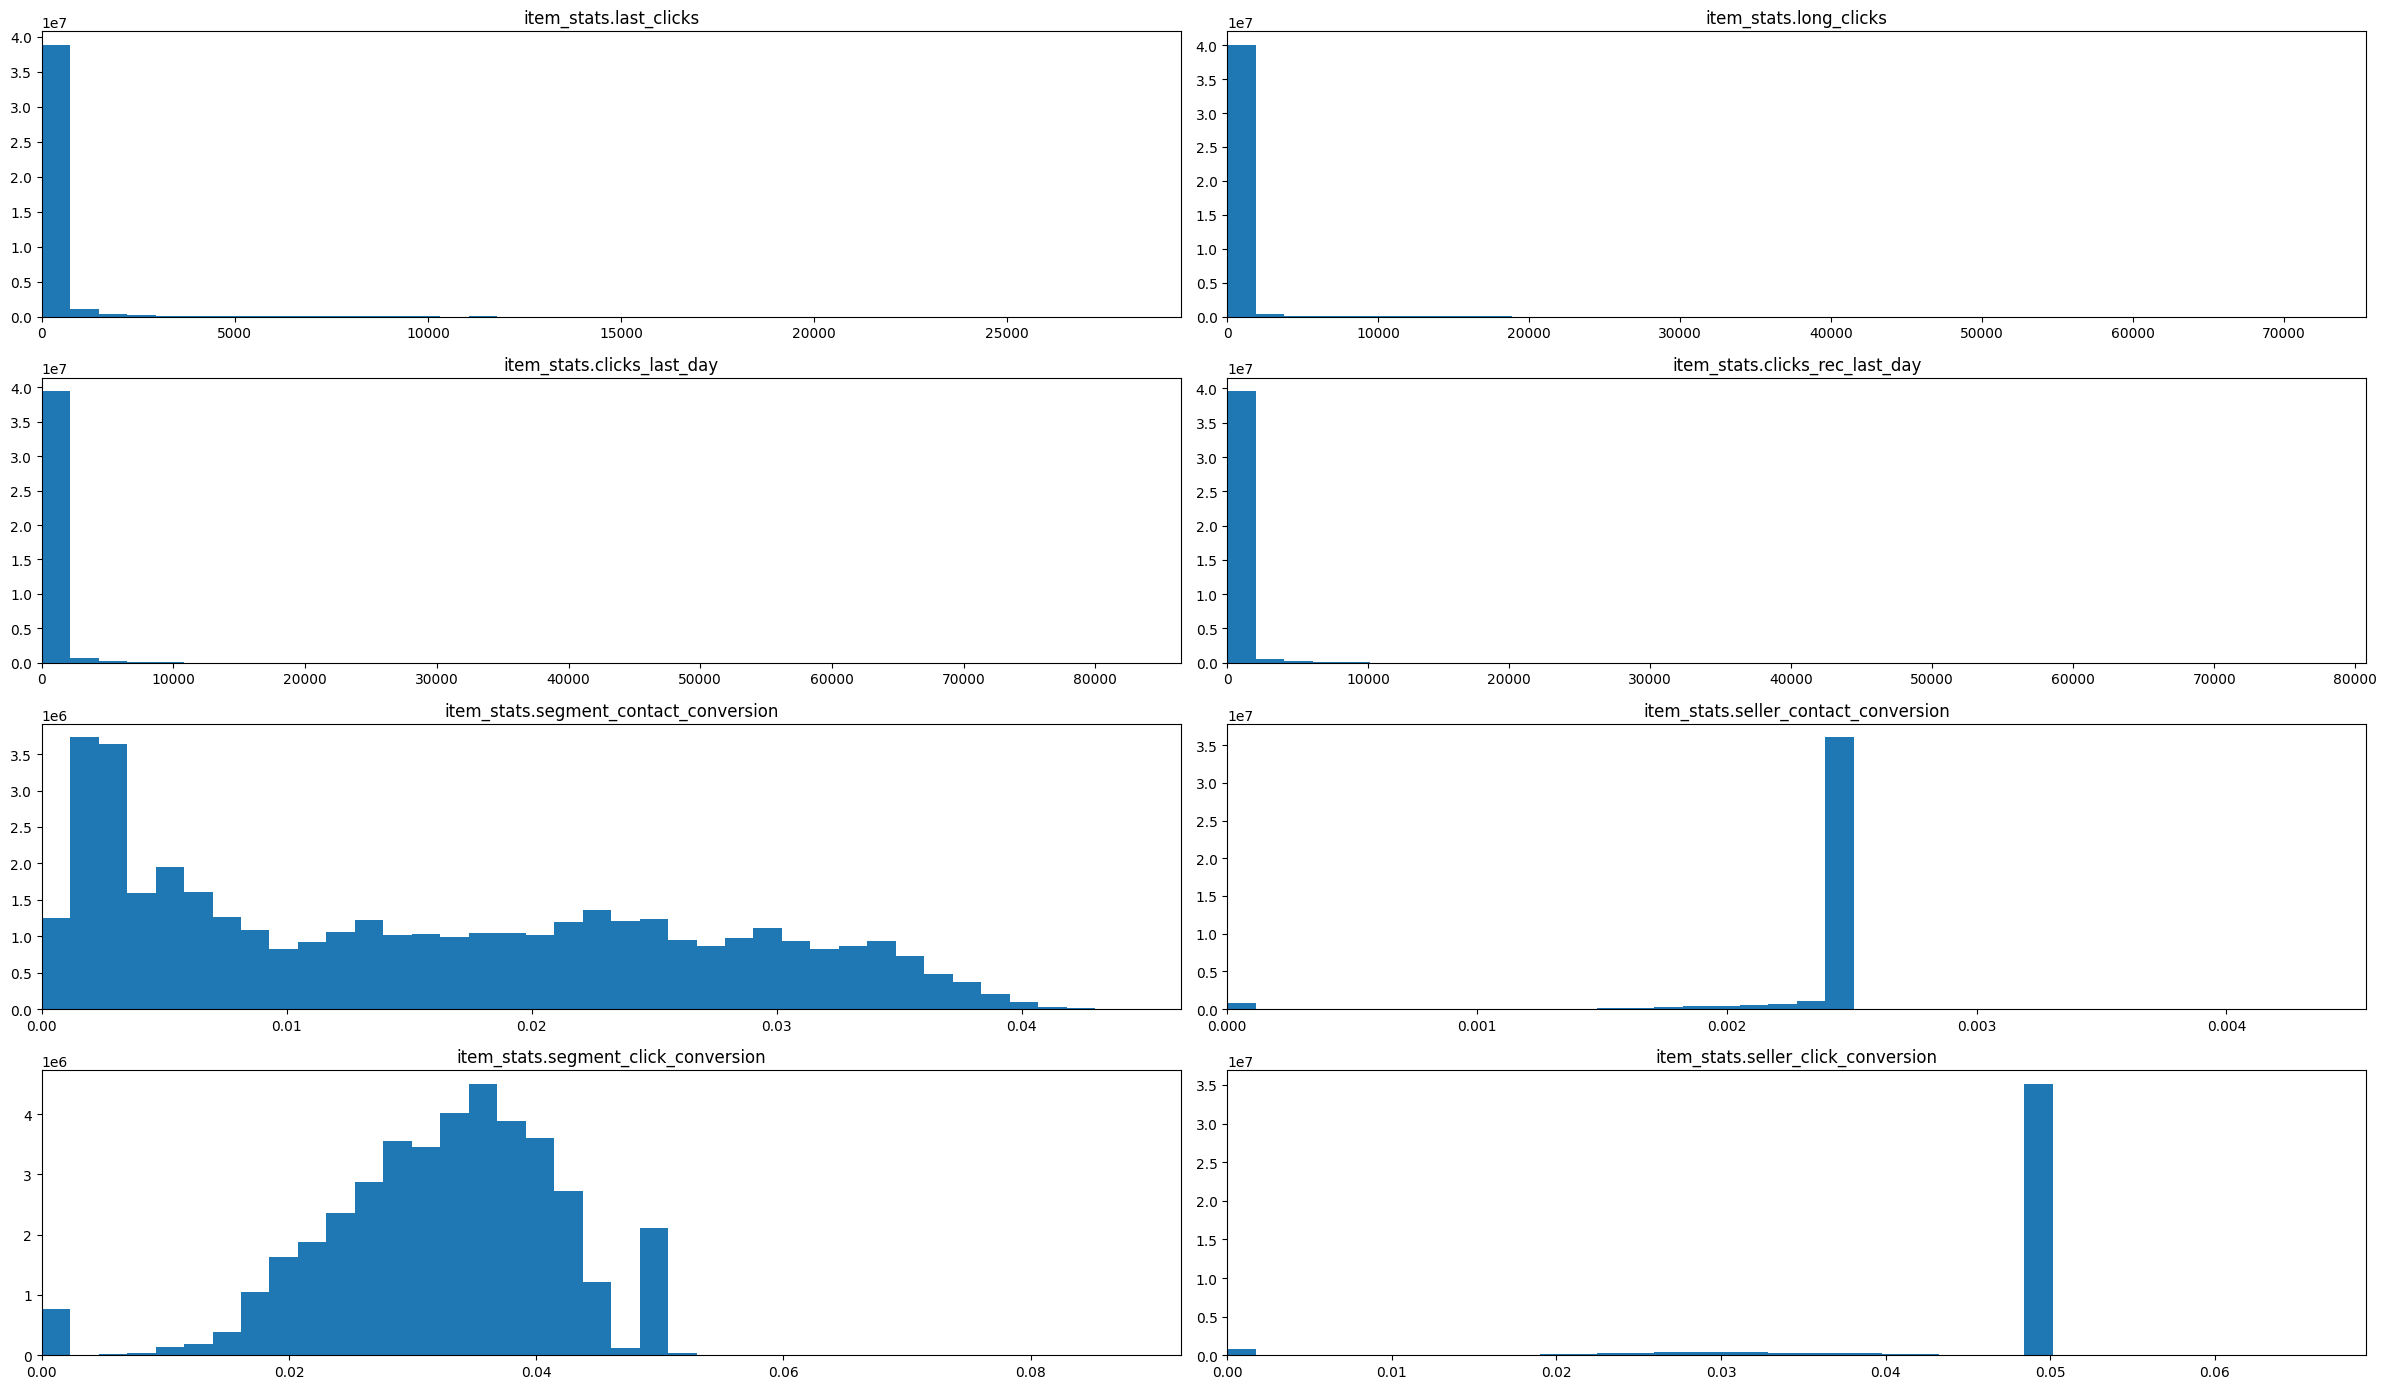

In [32]:
plt.figure(figsize=(24, 14))
for i, f in enumerate(features3):
    plt.subplot(4, 2, i + 1)
    plt.hist(train[f], bins=40)
    plt.title(f)
    plt.xlim((0, np.max(train[f])))
    
plt.tight_layout()

Забавно получилось, что мы так поделили - но кажется что все признаки из 2 группы и первые 4 из 3 можно удалить

In [33]:
cols_for_delete = [
       'item_stats.shows_last_day', 'item_stats.shows_rec',
       'item_stats.shows_rec_last_day', 'item_stats.contacts',
       'item_stats.contacts_last_day', 'item_stats.contacts_rec_last_day',
       'item_stats.contacts_rec', 'item_stats.last_contacts',
       'item_stats.delayed_contacts', 'item_stats.delayed_contacts_rec',
       'item_stats.clicks', 'item_stats.clicks_rec',
       'item_stats.last_clicks', 'item_stats.long_clicks',
]

train = train.drop(columns = cols_for_delete)
train.shape

(40623600, 33)

In [34]:
train = train.drop(columns = ['item_stats.clicks_last_day', 'item_stats.clicks_rec_last_day'])
train.shape

(40623600, 31)

Проверим остатки на корреляцию

<AxesSubplot: >

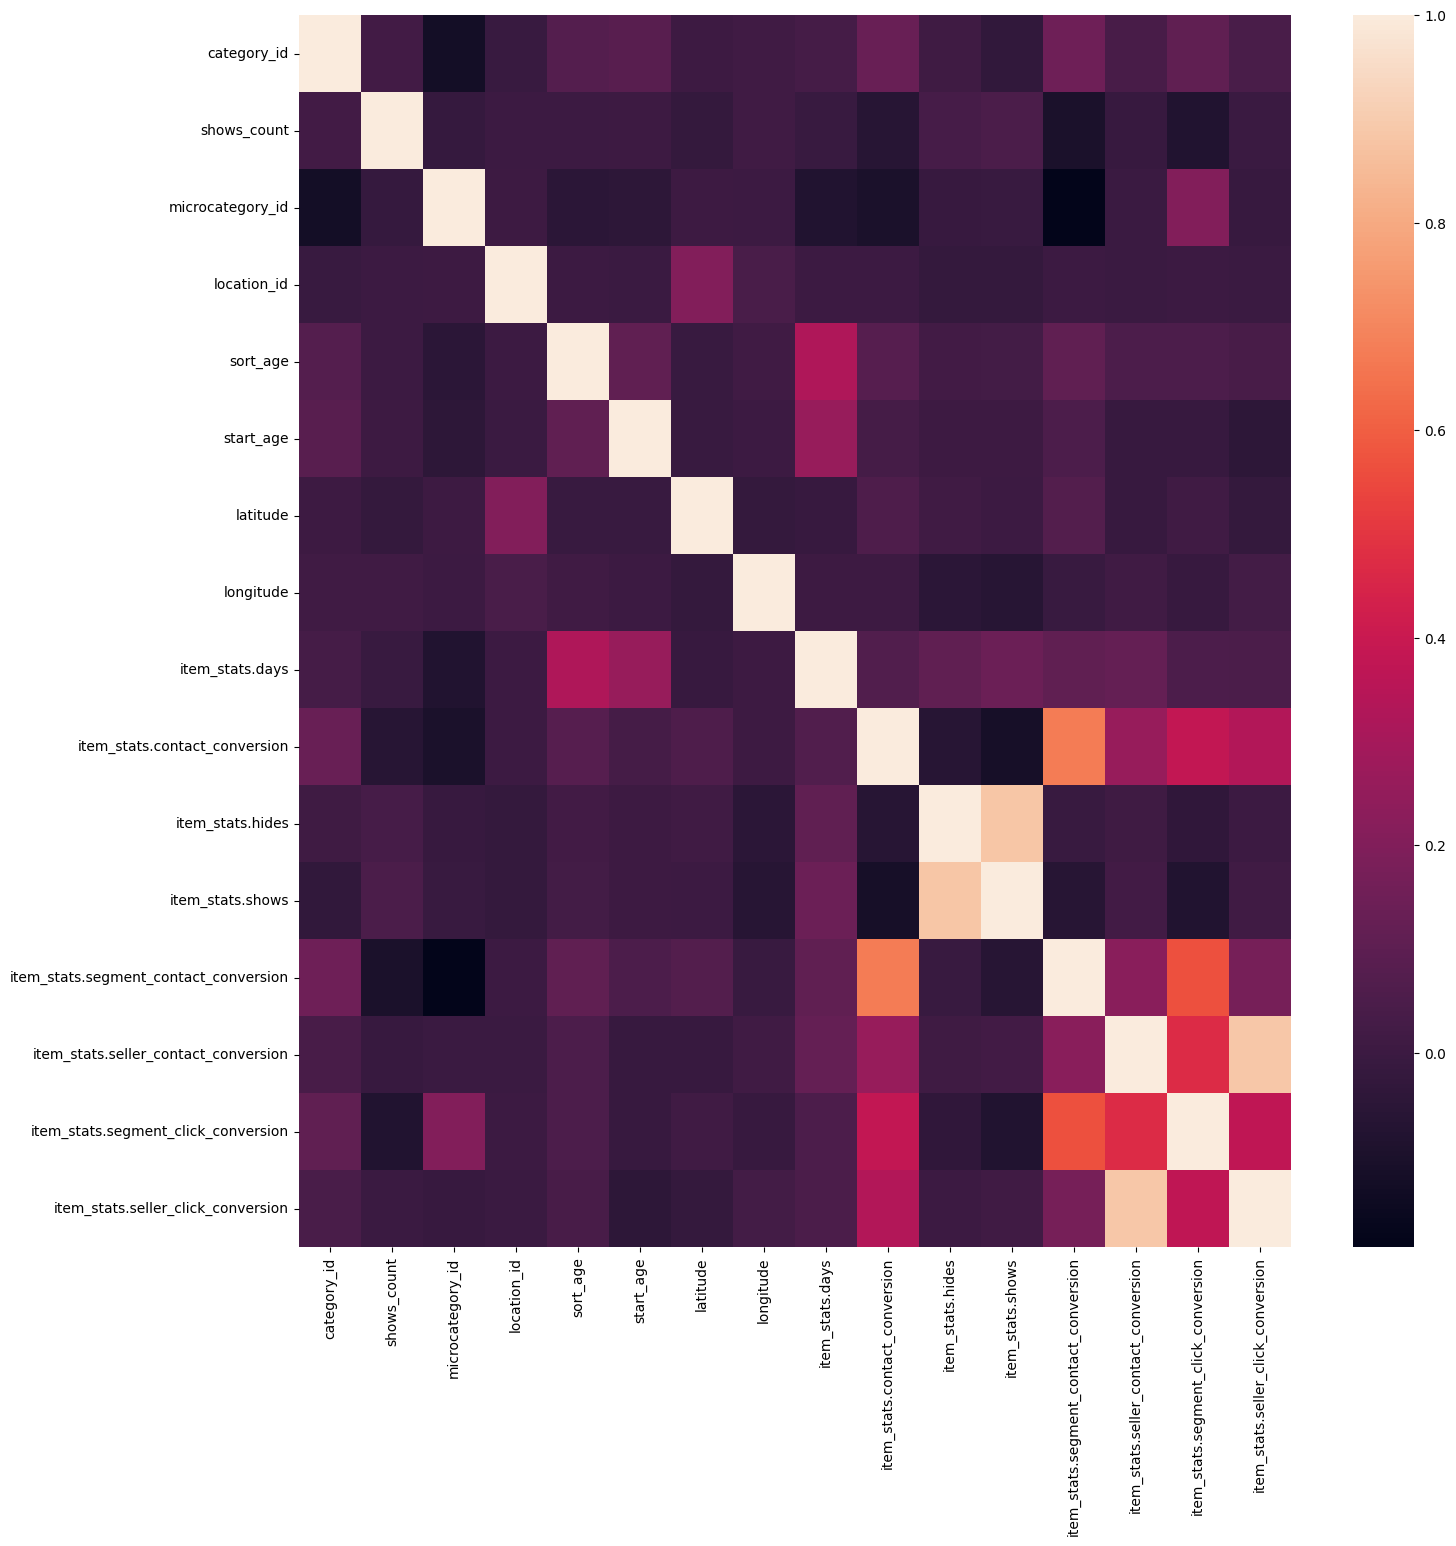

In [35]:
feats = [
       'category_id', 'shows_count', 'microcategory_id',
       'location_id', 'sort_age', 'start_age', 'latitude',
       'longitude', 'item_stats.days',
       'item_stats.contact_conversion', 'item_stats.hides', 'item_stats.shows',
        'item_stats.segment_contact_conversion',
       'item_stats.seller_contact_conversion',
       'item_stats.segment_click_conversion',
       'item_stats.seller_click_conversion',
]

plt.figure(figsize=(16, 16))
sns.heatmap(train[feats].corr())

Видим корреляцию 'item_stats.hides', 'item_stats.shows' и  'item_stats.seller_contact_conversion' с 'item_stats.seller_click_conversion' . Удалю 'item_stats.seller_contact_conversion' и 'item_stats.hides' ибо их строки корреляции чуть более выражены чем у других

In [36]:
train = train.drop(columns = ['item_stats.seller_contact_conversion', 'item_stats.hides'])
train.shape

(40623600, 29)

На этом обработку данных я планирую закончить. Почему?

1) Обработка категориальных не потребовалась
2) С обработкой пропусков - я сделала что смогла
3) Так как датасет достаточно полный (присутствует много бесполезной информации) я считаю, что никаких новых признаков добавлять не надо
4) Оставшиеся были изучены на корреляцию и различность значений

Итого чего я добилась на этом шаге:
1) Удалила из данных 20 признаков - список ниже
2) Избавилась хоть от какого то числа пропусков в данных
3) А также сильно зависимых признаков

Удаленные признаки:
'price', 'model_b_f1',
'item_stats.shows_last_day', 'item_stats.shows_rec',
'item_stats.shows_rec_last_day', 'item_stats.contacts',
'item_stats.contacts_last_day', 'item_stats.contacts_rec_last_day',
'item_stats.contacts_rec', 'item_stats.last_contacts',
'item_stats.delayed_contacts', 'item_stats.delayed_contacts_rec',
'item_stats.clicks', 'item_stats.clicks_rec',
'item_stats.last_clicks', 'item_stats.long_clicks',
'item_stats.clicks_last_day', 'item_stats.clicks_rec_last_day',
'item_stats.seller_contact_conversion', 'item_stats.hides'



# 2. Выбор модели

Так как данная задача предполагает работу с группировкой значений и тд, а я не знаю других моделей кроме lightgbm которые в это умеют - я также как и в бейзлайне решила использовать lightgbm.

В первую очередь хочу протестировать ту же модель, что и была в бейзлайне

In [47]:
!brew install libomp

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
autocorrect                hysteria                   pomsky
bazarr                     iir1                       postgresql@15
bdftopcf                   jj                         proxsuite
bindgen                    joker                      python-gdbm@3.11
btrfs-progs                json2tsv                   python-lsp-server
camlp-streams              kustomizer                 python-tk@3.11
cbindgen                   libdivide                  python-typing-extensions
cdsclient                  libemf2svg                 python@3.11
cloudprober                libgrapheme                quilt-installer
cmctl                      libretls                   rnr
cntb                       libunibreak                rome
corrosion                  liburing                   ruff
curlcpp                    license-eye                sambamba
dronedb                    

In [48]:
!python3 -m pip install lightgbm

In [49]:
import lightgbm
from lightgbm.callback import early_stopping

In [13]:
TARGET = 'target'
REQUEST_ID = 'request_id'

In [6]:
def df_to_dict(df: pd.DataFrame):
    return df.groupby(REQUEST_ID).item_id.apply(list).to_dict()

def mapk_df(df_with_prediction: pd.DataFrame, k: int) -> float:
    df_sorted = df_with_prediction.sort_values(['request_id', 'prediction'], ascending=[True, False])
    df_sorted['rank'] = df_sorted.groupby('request_id').cumcount()
    top = df_sorted[df_sorted['rank'] < k]
    pred_dict = df_to_dict(top)
    ans_dict = df_to_dict(df_sorted.query('target == 1'))
    
    predicted = []
    actual = []
    for k in ans_dict:
        predicted.append(pred_dict[k])
        actual.append(ans_dict[k])
        
    return mapk(actual, predicted, k)


def apk(actual, predicted, k=30):

    if not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=30):
    return sum([apk(a, p, k) for a, p in zip(actual, predicted)]) / len(actual)

In [7]:
def get_group_for_lgb(sorted_vals):
    curr_val = sorted_vals[0]
    cnt = 1
    groups = []
    for val in sorted_vals[1:]:
        if val != curr_val:
            groups.append(cnt)
            curr_val = val
            cnt = 1
        else:
            cnt += 1

    groups.append(cnt)

    return groups

In [8]:
def train_val_test_split(
        df: pd.DataFrame,
        split_column: str,
        val_part: float = 0.1,
        test_part: float = 0.1,
        seed: int = 32,
) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    random.seed(seed)
    unique_values = df[split_column].unique().tolist()
    random.shuffle(unique_values)
    val_start = int(len(unique_values) * (1 - val_part - test_part))
    test_start = int(len(unique_values) * (1 - test_part))
    train_ids = unique_values[:val_start]
    val_ids = unique_values[val_start: test_start]
    test_ids = unique_values[test_start:]

    return (
        df[df[split_column].isin(train_ids)],
        df[df[split_column].isin(val_ids)],
        df[df[split_column].isin(test_ids)],
    )


In [9]:
def train_lightgbm(ranking_df: pd.DataFrame, features: list):
    train, val, test = train_val_test_split(ranking_df, REQUEST_ID, val_part=0.1, test_part=0.1)
    X_train, y_train, train_groups = train[features], train[TARGET], get_group_for_lgb(train[REQUEST_ID].values)
    X_val, y_val, val_groups = val[features], val[TARGET], get_group_for_lgb(val[REQUEST_ID].values)

    lgb_train = lightgbm.Dataset(
        X_train, y_train, categorical_feature=['category_id'],
        group=train_groups, free_raw_data=False
    )
    lgb_eval = lightgbm.Dataset(
        X_val, y_val, reference=lgb_train, categorical_feature=['category_id'],
        group=val_groups, free_raw_data=False
    )


    model = lightgbm.train(
        {'objective': 'binary', 'metric': 'map', 'eval_at': [8, 30], 'learning_rate': 0.05},
        lgb_train,
        valid_sets=[lgb_eval],
        callbacks=[
            early_stopping(50),
            lightgbm.print_evaluation(10)
        ],
    )
    
    test['prediction'] = model.predict(test[features])
    print(f'map@30 on holdout test: {mapk_df(test, 30)}')
    

    return model

In [10]:
features = [
       'category_id','model_a_score',
       'model_a_rank', 'model_b_score', 'model_b_rank',
       'model_b_f2', 'model_b_f3', 'model_c_score', 'model_c_rank',
       'model_d_score', 'model_d_rank', 'shows_count', 'microcategory_id',
       'location_id', 'sort_age', 'start_age', 'latitude',
       'longitude', 'item_stats.days',
       'item_stats.contact_conversion', 'item_stats.shows',
       'item_stats.segment_contact_conversion',
       'item_stats.segment_click_conversion',
       'item_stats.seller_click_conversion',
]

In [56]:
model = train_lightgbm(train, features)

/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.794469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.0976247	valid_0's map@30: 0.112198
[20]	valid_0's map@8: 0.102427	valid_0's map@30: 0.117462
[30]	valid_0's map@8: 0.105401	valid_0's map@30: 0.120796
[40]	valid_0's map@8: 0.106919	valid_0's map@30: 0.12246
[50]	valid_0's map@8: 0.108787	valid_0's map@30: 0.124168
[60]	valid_0's map@8: 0.110414	valid_0's map@30: 0.125821
[70]	valid_0's map@8: 0.11174	valid_0's map@30: 0.127146
[80]	valid_0's map@8: 0.112932	valid_0's map@30: 0.128435
[90]	valid_0's map@8: 0.114029	valid_0's map@30: 0.129596
[100]	valid_0's map@8: 0.115393	valid_0's map@30: 0.130942
Did not meet early stopping. Best iteration is:
[100]	valid_0's map@8: 0.115393	valid_0's map@30: 0.130942


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_41232/3952206437.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12534654107394147


Что хочется отметить сразу? Что только при обработке данных удалось улучшить значения метрики, полученные кодом бейзлайна! Но на этом мы останавливаться не будем.

# 3. Оптимизация модели. Подбор гиперпараметров.

Теперь когда обработаны данные и зафиксирована примитивная модель - осталось подобрать гиперпараметры.

Я буду рассматривать 'learning_rate' и 'num_iterations'

Начнем с lr. Чуточку перепишем код train чтоб он возвращал еще значение метрики на holdout тесте - по этому значению и будем подбирать оптимальные параметры

In [15]:
def train_lightgbm_with_lr(ranking_df, features, lr):
    train, val, test = train_val_test_split(ranking_df, REQUEST_ID, val_part=0.1, test_part=0.1)
    X_train, y_train, train_groups = train[features], train[TARGET], get_group_for_lgb(train[REQUEST_ID].values)
    X_val, y_val, val_groups = val[features], val[TARGET], get_group_for_lgb(val[REQUEST_ID].values)

    lgb_train = lightgbm.Dataset(
        X_train, y_train, categorical_feature=['category_id'],
        group=train_groups, free_raw_data=False
    )
    lgb_eval = lightgbm.Dataset(
        X_val, y_val, reference=lgb_train, categorical_feature=['category_id'],
        group=val_groups, free_raw_data=False
    )


    model = lightgbm.train(
        {'objective': 'binary', 'metric': 'map', 'eval_at': [8, 30], 'learning_rate': lr},
        lgb_train,
        valid_sets=[lgb_eval],
        callbacks=[
            early_stopping(50),
            lightgbm.print_evaluation(10)
        ],
    )
    
    test['prediction'] = model.predict(test[features])
    metr = mapk_df(test, 30)
    print(f'map@30 on holdout test: {metr}')

    return metr

In [16]:
lrs = [0.01, 0.05, 0.1, 0.25, 0.5]
metrics = []

for lr in lrs:
    m = train_lightgbm_with_lr(train, features, lr)
    metrics.append(m)

/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.846396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.0895438	valid_0's map@30: 0.103977
[20]	valid_0's map@8: 0.0947769	valid_0's map@30: 0.109173
[30]	valid_0's map@8: 0.0964119	valid_0's map@30: 0.111154
[40]	valid_0's map@8: 0.0986406	valid_0's map@30: 0.113404
[50]	valid_0's map@8: 0.100024	valid_0's map@30: 0.114926
[60]	valid_0's map@8: 0.101285	valid_0's map@30: 0.116085
[70]	valid_0's map@8: 0.101889	valid_0's map@30: 0.116839
[80]	valid_0's map@8: 0.102653	valid_0's map@30: 0.117624
[90]	valid_0's map@8: 0.102835	valid_0's map@30: 0.117874
[100]	valid_0's map@8: 0.103287	valid_0's map@30: 0.11839
Did not meet early stopping. Best iteration is:
[100]	valid_0's map@8: 0.103287	valid_0's map@30: 0.11839


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/3626151032.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.1122467294557058


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.688348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.0976247	valid_0's map@30: 0.112198
[20]	valid_0's map@8: 0.102427	valid_0's map@30: 0.117462
[30]	valid_0's map@8: 0.105401	valid_0's map@30: 0.120796
[40]	valid_0's map@8: 0.106919	valid_0's map@30: 0.12246
[50]	valid_0's map@8: 0.108787	valid_0's map@30: 0.124168
[60]	valid_0's map@8: 0.110414	valid_0's map@30: 0.125821
[70]	valid_0's map@8: 0.11174	valid_0's map@30: 0.127146
[80]	valid_0's map@8: 0.112932	valid_0's map@30: 0.128435
[90]	valid_0's map@8: 0.114029	valid_0's map@30: 0.129596
[100]	valid_0's map@8: 0.115393	valid_0's map@30: 0.130942
Did not meet early stopping. Best iteration is:
[100]	valid_0's map@8: 0.115393	valid_0's map@30: 0.130942


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/3626151032.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12534654107394147


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.786938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.100583	valid_0's map@30: 0.1158
[20]	valid_0's map@8: 0.105831	valid_0's map@30: 0.121122
[30]	valid_0's map@8: 0.109275	valid_0's map@30: 0.124783
[40]	valid_0's map@8: 0.112055	valid_0's map@30: 0.127566
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286
[60]	valid_0's map@8: 0.114394	valid_0's map@30: 0.130008
[70]	valid_0's map@8: 0.115583	valid_0's map@30: 0.131224
[80]	valid_0's map@8: 0.116909	valid_0's map@30: 0.132509
[90]	valid_0's map@8: 0.118049	valid_0's map@30: 0.133814
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361
Did not meet early stopping. Best iteration is:
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/3626151032.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12864874477189603


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.772865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.0939657	valid_0's map@30: 0.109176
[20]	valid_0's map@8: 0.101337	valid_0's map@30: 0.11726
[30]	valid_0's map@8: 0.1068	valid_0's map@30: 0.122662
[40]	valid_0's map@8: 0.109631	valid_0's map@30: 0.125609
[50]	valid_0's map@8: 0.112284	valid_0's map@30: 0.128349
[60]	valid_0's map@8: 0.113452	valid_0's map@30: 0.129605
[70]	valid_0's map@8: 0.113896	valid_0's map@30: 0.12988
[80]	valid_0's map@8: 0.113648	valid_0's map@30: 0.12985
[90]	valid_0's map@8: 0.113514	valid_0's map@30: 0.12971
[100]	valid_0's map@8: 0.1139	valid_0's map@30: 0.130062
Did not meet early stopping. Best iteration is:
[74]	valid_0's map@8: 0.114018	valid_0's map@30: 0.130059


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/3626151032.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.1235802955200662


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.808881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.0862868	valid_0's map@30: 0.101242
[20]	valid_0's map@8: 0.0950683	valid_0's map@30: 0.1105
[30]	valid_0's map@8: 0.0990514	valid_0's map@30: 0.114716
[40]	valid_0's map@8: 0.101382	valid_0's map@30: 0.117054
[50]	valid_0's map@8: 0.103116	valid_0's map@30: 0.118935
[60]	valid_0's map@8: 0.103696	valid_0's map@30: 0.119433
[70]	valid_0's map@8: 0.103957	valid_0's map@30: 0.119734
[80]	valid_0's map@8: 0.103764	valid_0's map@30: 0.119576
[90]	valid_0's map@8: 0.104122	valid_0's map@30: 0.119837
[100]	valid_0's map@8: 0.103814	valid_0's map@30: 0.119562
Did not meet early stopping. Best iteration is:
[85]	valid_0's map@8: 0.104215	valid_0's map@30: 0.119966


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/3626151032.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.11184283439578512


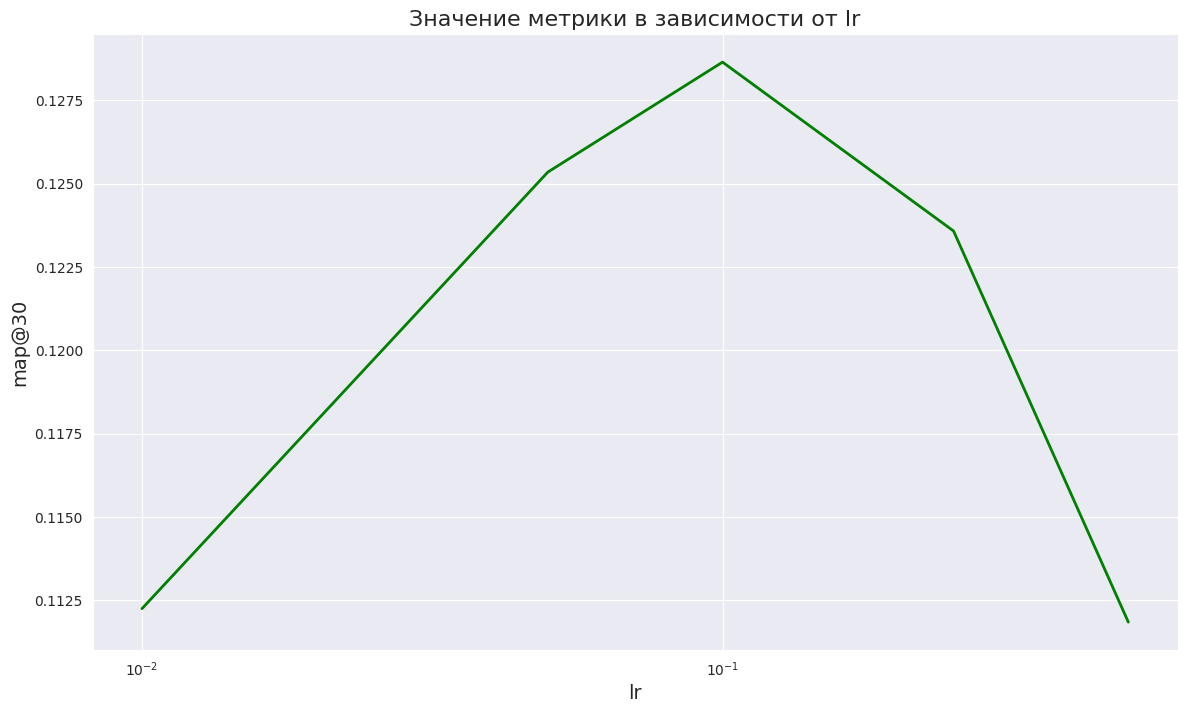

In [20]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(14, 8))
    plt.title('Значение метрики в зависимости от lr', fontsize=16)
    plt.plot(lrs, metrics, c='green', lw=2)
    plt.xlabel('lr', fontsize=14)
    plt.ylabel('map@30', fontsize=14)
    plt.xscale('log')

Действительно, лучшим значением с отрывом является 0.1, а не 0.5 как в бейзлане

Теперь проведем аналогичный эксперимент для 'num_iterations', при этом зафикс lr

In [21]:
def train_lightgbm_with_iter(ranking_df, features, it):
    train, val, test = train_val_test_split(ranking_df, REQUEST_ID, val_part=0.1, test_part=0.1)
    X_train, y_train, train_groups = train[features], train[TARGET], get_group_for_lgb(train[REQUEST_ID].values)
    X_val, y_val, val_groups = val[features], val[TARGET], get_group_for_lgb(val[REQUEST_ID].values)

    lgb_train = lightgbm.Dataset(
        X_train, y_train, categorical_feature=['category_id'],
        group=train_groups, free_raw_data=False
    )
    lgb_eval = lightgbm.Dataset(
        X_val, y_val, reference=lgb_train, categorical_feature=['category_id'],
        group=val_groups, free_raw_data=False
    )


    model = lightgbm.train(
        {'objective': 'binary', 'metric': 'map', 'eval_at': [8, 30], 'learning_rate': 0.1, 'num_iterations': it},
        lgb_train,
        valid_sets=[lgb_eval],
        callbacks=[
            early_stopping(50),
            lightgbm.print_evaluation(10)
        ],
    )
    
    test['prediction'] = model.predict(test[features])
    metr = mapk_df(test, 30)
    print(f'map@30 on holdout test: {metr}')

    return metr

In [22]:
iterations = [50, 100, 150, 200]
metrics = []

for it in iterations:
    m = train_lightgbm_with_iter(train, features, it)
    metrics.append(m)

/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.728619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.100583	valid_0's map@30: 0.1158
[20]	valid_0's map@8: 0.105831	valid_0's map@30: 0.121122
[30]	valid_0's map@8: 0.109275	valid_0's map@30: 0.124783
[40]	valid_0's map@8: 0.112055	valid_0's map@30: 0.127566
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286
Did not meet early stopping. Best iteration is:
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/1050639728.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12299830351626363


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.743518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.100583	valid_0's map@30: 0.1158
[20]	valid_0's map@8: 0.105831	valid_0's map@30: 0.121122
[30]	valid_0's map@8: 0.109275	valid_0's map@30: 0.124783
[40]	valid_0's map@8: 0.112055	valid_0's map@30: 0.127566
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286
[60]	valid_0's map@8: 0.114394	valid_0's map@30: 0.130008
[70]	valid_0's map@8: 0.115583	valid_0's map@30: 0.131224
[80]	valid_0's map@8: 0.116909	valid_0's map@30: 0.132509
[90]	valid_0's map@8: 0.118049	valid_0's map@30: 0.133814
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361
Did not meet early stopping. Best iteration is:
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361


/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/1050639728.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12864874477189603


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.790144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.100583	valid_0's map@30: 0.1158
[20]	valid_0's map@8: 0.105831	valid_0's map@30: 0.121122
[30]	valid_0's map@8: 0.109275	valid_0's map@30: 0.124783
[40]	valid_0's map@8: 0.112055	valid_0's map@30: 0.127566
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286
[60]	valid_0's map@8: 0.114394	valid_0's map@30: 0.130008
[70]	valid_0's map@8: 0.115583	valid_0's map@30: 0.131224
[80]	valid_0's map@8: 0.116909	valid_0's map@30: 0.132509
[90]	valid_0's map@8: 0.118049	valid_0's map@30: 0.133814
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361
[110]	valid_0's map@8: 0.11883	valid_0's map@30: 0.13473
[120]	valid_0's map@8: 0.119509	valid_0's map@30: 0.135504
[130]	valid_0's map@8: 0.119538	valid_0's map@30: 0.13

/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/1050639728.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12939831741239075


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.936144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.100583	valid_0's map@30: 0.1158
[20]	valid_0's map@8: 0.105831	valid_0's map@30: 0.121122
[30]	valid_0's map@8: 0.109275	valid_0's map@30: 0.124783
[40]	valid_0's map@8: 0.112055	valid_0's map@30: 0.127566
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286
[60]	valid_0's map@8: 0.114394	valid_0's map@30: 0.130008
[70]	valid_0's map@8: 0.115583	valid_0's map@30: 0.131224
[80]	valid_0's map@8: 0.116909	valid_0's map@30: 0.132509
[90]	valid_0's map@8: 0.118049	valid_0's map@30: 0.133814
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361
[110]	valid_0's map@8: 0.11883	valid_0's map@30: 0.13473
[120]	valid_0's map@8: 0.119509	valid_0's map@30: 0.135504
[130]	valid_0's map@8: 0.119538	valid_0's map@30: 0.13

/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/1050639728.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12939831741239075


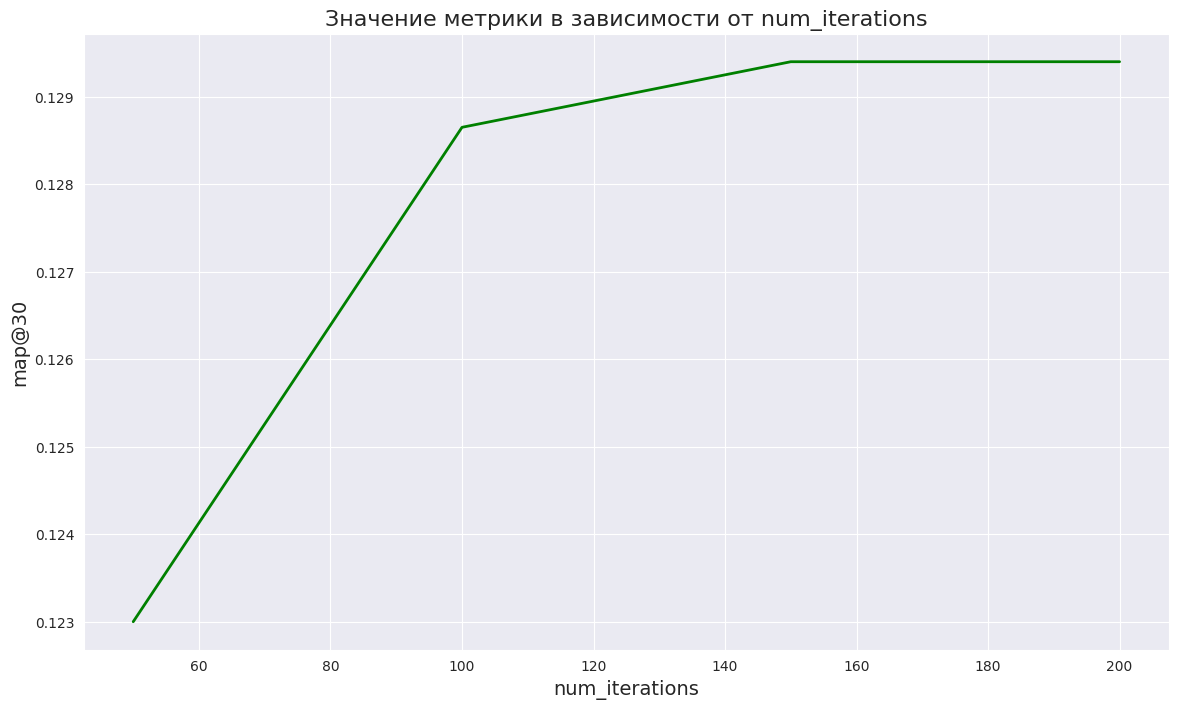

In [23]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(14, 8))
    plt.title('Значение метрики в зависимости от num_iterations', fontsize=16)
    plt.plot(iterations, metrics, c='green', lw=2)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('map@30', fontsize=14)

Получается, мы еще смогли улучшить метрику, однако более чем 150 не имеет смысла задавать значения ибо выполняется условие ранней остановки на 147 итерации

Думаю что теперб уже мы готовы засылать решение в контест

# 4. Решение.

In [24]:
def train_lightgbm(ranking_df: pd.DataFrame, features: list):
    train, val, test = train_val_test_split(ranking_df, REQUEST_ID, val_part=0.1, test_part=0.1)
    X_train, y_train, train_groups = train[features], train[TARGET], get_group_for_lgb(train[REQUEST_ID].values)
    X_val, y_val, val_groups = val[features], val[TARGET], get_group_for_lgb(val[REQUEST_ID].values)

    lgb_train = lightgbm.Dataset(
        X_train, y_train, categorical_feature=['category_id'],
        group=train_groups, free_raw_data=False
    )
    lgb_eval = lightgbm.Dataset(
        X_val, y_val, reference=lgb_train, categorical_feature=['category_id'],
        group=val_groups, free_raw_data=False
    )


    model = lightgbm.train(
        {'objective': 'binary', 'metric': 'map', 'eval_at': [8, 30], 'learning_rate': 0.1, 'num_iterations': 150},
        lgb_train,
        valid_sets=[lgb_eval],
        callbacks=[
            early_stopping(50),
            lightgbm.print_evaluation(10)
        ],
    )
    
    test['prediction'] = model.predict(test[features])
    print(f'map@30 on holdout test: {mapk_df(test, 30)}')

    return model

In [25]:
model = train_lightgbm(train, features)

/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:57: UserWarning: 'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. Use 'log_evaluation()' callback instead.
  _log_warning("'print_evaluation()' callback is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 176182, number of negative: 32322518
[LightGBM] [Info] Total groups: 108329, total data: 32498700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.003626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 32498700, number of used features: 24


/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Total groups: 13541, total data: 4062300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005421 -> initscore=-5.212002
[LightGBM] [Info] Start training from score -5.212002
Training until validation scores don't improve for 50 rounds
[10]	valid_0's map@8: 0.100583	valid_0's map@30: 0.1158
[20]	valid_0's map@8: 0.105831	valid_0's map@30: 0.121122
[30]	valid_0's map@8: 0.109275	valid_0's map@30: 0.124783
[40]	valid_0's map@8: 0.112055	valid_0's map@30: 0.127566
[50]	valid_0's map@8: 0.113105	valid_0's map@30: 0.1286
[60]	valid_0's map@8: 0.114394	valid_0's map@30: 0.130008
[70]	valid_0's map@8: 0.115583	valid_0's map@30: 0.131224
[80]	valid_0's map@8: 0.116909	valid_0's map@30: 0.132509
[90]	valid_0's map@8: 0.118049	valid_0's map@30: 0.133814
[100]	valid_0's map@8: 0.11864	valid_0's map@30: 0.134361
[110]	valid_0's map@8: 0.11883	valid_0's map@30: 0.13473
[120]	valid_0's map@8: 0.119509	valid_0's map@30: 0.135504
[130]	valid_0's map@8: 0.119538	valid_0's map@30: 0.13

/var/folders/x3/9026029j76l2gjgxkhc_6n_9md408r/T/ipykernel_45206/1028597987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(test[features])


map@30 on holdout test: 0.12939831741239075


In [26]:
del train

In [27]:
model.save_model('lgbm_train.txt')

In [28]:
# load from model:
model = lightgbm.Booster(model_file='lgbm_train.txt')

In [29]:
test = pd.read_parquet('Downloads/items_test.pq')

In [30]:
def create_submission(filename, model, test, k: int = 30):
    test['pred'] = model.predict(test[model.feature_name()])
    test_sorted = test.sort_values(['request_id', 'pred'], ascending=[True, False])
    test_sorted['rank'] = test_sorted.groupby('request_id').cumcount()
    top = test_sorted[test_sorted['rank'] < k]
    subm = top[['request_id', 'item_id']].groupby('request_id')['item_id'].apply(lambda x: ' '.join(map(str, x)))
    subm_df = subm.to_frame().reset_index().rename(columns={'item_id': 'item_ids'})
    subm_df.to_csv(filename, index=False)

In [31]:
create_submission('lgbm.csv', model, test)